In [9]:
import tensorflow as tf
import gym
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
import time
import scipy.signal
from tqdm import tqdm




# Storage Model

In [10]:
def discounted_cumulative_sums(x, discount):
    # Discounted cumulative sums of vectors for computing rewards-to-go and advantage estimates
    return scipy.signal.lfilter([1], [1, float(-discount)], x[::-1], axis=0)[::-1]

def logprobabilities(logits, a):
    # Compute the log-probabilities of taking actions a by using the logits (i.e. the output of the actor)
    logprobabilities_all = tf.nn.log_softmax(logits)
    logprobability = tf.reduce_sum(
        tf.one_hot(a, num_actions) * logprobabilities_all, axis=1
    )
    return logprobability

class Trajectory_Storage:
    # T for storing trajectories
    def __init__(self, observation_dimensions, size, gamma=0.99, lam=0.95):
        # T initialization
        self.observation_buffer = np.zeros(
            (size, observation_dimensions), dtype=np.float32
        )
        self.action_buffer = np.zeros(size, dtype=np.int32)
        self.advantage_buffer = np.zeros(size, dtype=np.float32)
        self.reward_buffer = np.zeros(size, dtype=np.float32)
        self.return_buffer = np.zeros(size, dtype=np.float32)
        self.value_buffer = np.zeros(size, dtype=np.float32)
        self.logprobability_buffer = np.zeros(size, dtype=np.float32)
        self.gamma, self.lam = gamma, lam
        self.pointer, self.trajectory_start_index = 0, 0

    def store(self, observation, action, reward, value, logprobability):
        # Append one step of agent-environment interaction
        self.observation_buffer[self.pointer] = observation
        self.action_buffer[self.pointer] = action
        self.reward_buffer[self.pointer] = reward
        self.value_buffer[self.pointer] = value
        self.logprobability_buffer[self.pointer] = logprobability
        self.pointer += 1

    def finish_trajectory(self, last_value=0):
        # Finish the trajectory by computing advantage estimates and rewards-to-go
        path_slice = slice(self.trajectory_start_index, self.pointer)
        rewards = np.append(self.reward_buffer[path_slice], last_value)
        values = np.append(self.value_buffer[path_slice], last_value)

        deltas = rewards[:-1] + self.gamma * values[1:] - values[:-1]

        self.advantage_buffer[path_slice] = discounted_cumulative_sums(
            deltas, self.gamma * self.lam
        )
        self.return_buffer[path_slice] = discounted_cumulative_sums(
            rewards, self.gamma
        )[:-1]

        self.trajectory_start_index = self.pointer

    def get(self):
        # Get all data of the buffer and normalize the advantages
        self.pointer, self.trajectory_start_index = 0, 0
        advantage_mean, advantage_std = (
            np.mean(self.advantage_buffer),
            np.std(self.advantage_buffer),
        )
        self.advantage_buffer = (self.advantage_buffer - advantage_mean) / advantage_std
        return (
            self.observation_buffer,
            self.action_buffer,
            self.advantage_buffer,
            self.return_buffer,
            self.logprobability_buffer,
        )


# Actor Model


In [11]:
class Actor(Model):
    def __init__(self):
        super(Actor, self).__init__()


        self.l = [
            Dense(64, activation="tanh", kernel_initializer=tf.random_normal_initializer
            (stddev=0.02)),
            Dense(64, activation="tanh", kernel_initializer=tf.random_normal_initializer
            (stddev=0.02)),
            Dense(2, activation="tanh", kernel_regularizer=tf.random_normal_initializer(stddev=0.02))
        ]

    #@tf.function        
    def call(self, x):
        for l in self.l:
            x = l(x)
        return x

        

#@tf.function
def sample_action(observation):
    logits = actor(observation)
   # tf.print(type(logits))
    action = tf.squeeze(tf.random.categorical(logits, 1), axis=1)
   # tf.print(action)
    return logits, action

# Critic Model

In [12]:
class Critic(Model):
    def __init__(self):
        super(Critic, self).__init__()

        self.l = [
            Dense(64, activation="tanh", kernel_initializer=tf.random_normal_initializer
            (stddev=0.02)),
            Dense(64, activation="tanh", kernel_initializer=tf.random_normal_initializer
            (stddev=0.02)),
            Dense(1, activation="tanh", kernel_regularizer=tf.random_normal_initializer(stddev=0.02))
        ]

    #@tf.function 
    def call(self, x):
        for l in self.l:
            x = l(x)
        return x

# Update Policy Function

Training the Actor Model Using the typical PPO-Clipping Method

In [13]:
# Train the policy by maxizing the PPO-Clip objective
@tf.function
def train_policy(
    observation_buffer, action_buffer, logprobability_buffer, advantage_buffer
):

    with tf.GradientTape() as tape:  # Record operations for automatic differentiation.
        ratio = tf.exp(
            logprobabilities(actor(observation_buffer), action_buffer)
            - logprobability_buffer
        )
        min_advantage = tf.where(
            advantage_buffer > 0,
            (1 + clip_ratio) * advantage_buffer,
            (1 - clip_ratio) * advantage_buffer,
        )

        policy_loss = -tf.reduce_mean(
            tf.minimum(ratio * advantage_buffer, min_advantage)
        )
    policy_grads = tape.gradient(policy_loss, actor.trainable_variables)
    # print("Policy grads: ")
    # print(policy_grads)
    # print("Actor Variables:")
    # print([actor.trainable_variables])
    # print(type(policy_grads), type(actor.trainable_variables))
    optimizer.apply_gradients(zip(policy_grads, actor.trainable_variables))

    kl = tf.reduce_mean(
        logprobability_buffer
        - logprobabilities(actor(observation_buffer), action_buffer)
    )
    kl = tf.reduce_sum(kl)
    return kl


# Train the value function by regression on mean-squared error
@tf.function
def train_value_function(observation_buffer, return_buffer):
    with tf.GradientTape() as tape:  # Record operations for automatic differentiation.
        value_loss = tf.reduce_mean((return_buffer - critic(observation_buffer)) ** 2)
    value_grads = tape.gradient(value_loss, critic.trainable_variables)
    optimizer_2.apply_gradients(zip(value_grads, critic.trainable_variables))

In [14]:
# define Hyperparameters
epochs = 40
steps_per_epoch = 4000
lr_actor = 3e-4
lr_critic = 1e-3
train_policy_iterations = 80
train_value_iterations = 80
clip_ratio = 0.2
target_kl = 0.01
optimizer = Adam()
optimizer_2 = Adam()

render = False

# Test Inits 

In [15]:
tf.keras.backend.clear_session()

# define environment
env = gym.make("CartPole-v1")
# get observation_dims and amount of possible actions (1 for CartPole-v1)
observation_dimensions = env.observation_space.shape[0]
num_actions = env.action_space.n

# create Storage for observations, actions, rewards etc during trajectory
T = Trajectory_Storage(observation_dimensions=observation_dimensions, size=steps_per_epoch)

# init the actor and critics model
actor = Actor()
critic = Critic()

# Initialize the observation, episode return and episode length
observation, episode_return, episode_length = env.reset(), 0, 0
mean_returns = []

# Training Loop

In [16]:
for epoch in range(epochs):
     # Initialize the sum of the returns, lengths and number of episodes for each epoch
    sum_return = 0
    sum_length = 0
    num_episodes = 0

    # Iterate over the steps of each epoch
    for t in tqdm(range(steps_per_epoch)):
        if render:
            env.render()

        # Get the logits, action, and take one step in the environment
        #print(observation)
        observation = observation.reshape(1, -1)
        
        #print(observation)
        logits, action = sample_action(observation)
        #print(logits)
        observation_new, reward, done, _ = env.step(action[0].numpy())
        episode_return += reward
        episode_length += 1
        #print(observation)
        # Get the value and log-probability of the action
        value_t = critic(observation)
        logprobability_t = logprobabilities(logits, action)

        # Store obs, act, rew, v_t, logp_pi_t
        T.store(observation, action, reward, value_t, logprobability_t)

        # Update the observation
        observation = observation_new

        # Finish trajectory if reached to a terminal state
        terminal = done
        if terminal or (t == steps_per_epoch - 1):
            last_value = 0 if done else critic(observation.reshape(1, -1))
            T.finish_trajectory(last_value)
            sum_return += episode_return
            sum_length += episode_length
            num_episodes += 1
            observation, episode_return, episode_length = env.reset(), 0, 0

    # Get values from the buffer
    (
        observation_buffer,
        action_buffer,
        advantage_buffer,
        return_buffer,
        logprobability_buffer,
    ) = T.get()

    # Update the policy and implement early stopping using KL divergence
    for _ in range(train_policy_iterations):
        kl = train_policy(
            observation_buffer, action_buffer, logprobability_buffer, advantage_buffer
        )
        if kl > 1.5 * target_kl:
            # Early Stopping
            break

    # Update the value function
    for _ in range(train_value_iterations):
        train_value_function(observation_buffer, return_buffer)

    # Print mean return and length for each epoch
    print(
        f" Epoch: {epoch + 1}. Mean Return: {sum_return / num_episodes}. Mean Length: {sum_length / num_episodes}"
    )
    mean_returns.append(sum_return/num_episodes)

100%|██████████| 4000/4000 [00:32<00:00, 123.54it/s]
2022-03-28 16:34:20.162395: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-28 16:34:20.452723: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


 Epoch: 1. Mean Return: 22.471910112359552. Mean Length: 22.471910112359552


100%|██████████| 4000/4000 [00:28<00:00, 142.75it/s]


 Epoch: 2. Mean Return: 30.76923076923077. Mean Length: 30.76923076923077


100%|██████████| 4000/4000 [00:26<00:00, 150.95it/s]


 Epoch: 3. Mean Return: 43.956043956043956. Mean Length: 43.956043956043956


100%|██████████| 4000/4000 [00:28<00:00, 141.30it/s]


 Epoch: 4. Mean Return: 86.95652173913044. Mean Length: 86.95652173913044


100%|██████████| 4000/4000 [00:36<00:00, 108.32it/s]


 Epoch: 5. Mean Return: 125.0. Mean Length: 125.0


100%|██████████| 4000/4000 [00:29<00:00, 137.80it/s]


 Epoch: 6. Mean Return: 181.8181818181818. Mean Length: 181.8181818181818


100%|██████████| 4000/4000 [00:28<00:00, 140.78it/s]


 Epoch: 7. Mean Return: 235.2941176470588. Mean Length: 235.2941176470588


100%|██████████| 4000/4000 [00:37<00:00, 106.36it/s]


 Epoch: 8. Mean Return: 210.52631578947367. Mean Length: 210.52631578947367


100%|██████████| 4000/4000 [00:25<00:00, 156.26it/s]


 Epoch: 9. Mean Return: 307.6923076923077. Mean Length: 307.6923076923077


100%|██████████| 4000/4000 [00:26<00:00, 153.06it/s]


 Epoch: 10. Mean Return: 363.6363636363636. Mean Length: 363.6363636363636


100%|██████████| 4000/4000 [00:27<00:00, 146.50it/s]


 Epoch: 11. Mean Return: 266.6666666666667. Mean Length: 266.6666666666667


100%|██████████| 4000/4000 [00:34<00:00, 116.56it/s]


 Epoch: 12. Mean Return: 210.52631578947367. Mean Length: 210.52631578947367


100%|██████████| 4000/4000 [00:26<00:00, 151.49it/s]


 Epoch: 13. Mean Return: 363.6363636363636. Mean Length: 363.6363636363636


100%|██████████| 4000/4000 [00:26<00:00, 150.08it/s]


 Epoch: 14. Mean Return: 307.6923076923077. Mean Length: 307.6923076923077


100%|██████████| 4000/4000 [00:37<00:00, 105.90it/s]


 Epoch: 15. Mean Return: 363.6363636363636. Mean Length: 363.6363636363636


100%|██████████| 4000/4000 [00:27<00:00, 144.32it/s]


 Epoch: 16. Mean Return: 400.0. Mean Length: 400.0


100%|██████████| 4000/4000 [00:28<00:00, 138.75it/s]


 Epoch: 17. Mean Return: 333.3333333333333. Mean Length: 333.3333333333333


100%|██████████| 4000/4000 [00:33<00:00, 121.19it/s]


 Epoch: 18. Mean Return: 363.6363636363636. Mean Length: 363.6363636363636


100%|██████████| 4000/4000 [00:30<00:00, 131.58it/s]


 Epoch: 19. Mean Return: 400.0. Mean Length: 400.0


100%|██████████| 4000/4000 [00:28<00:00, 139.59it/s]


 Epoch: 20. Mean Return: 444.44444444444446. Mean Length: 444.44444444444446


100%|██████████| 4000/4000 [00:28<00:00, 141.71it/s]


 Epoch: 21. Mean Return: 363.6363636363636. Mean Length: 363.6363636363636


100%|██████████| 4000/4000 [00:35<00:00, 112.66it/s]


 Epoch: 22. Mean Return: 333.3333333333333. Mean Length: 333.3333333333333


100%|██████████| 4000/4000 [00:27<00:00, 142.94it/s]


 Epoch: 23. Mean Return: 500.0. Mean Length: 500.0


100%|██████████| 4000/4000 [00:27<00:00, 142.87it/s]


 Epoch: 24. Mean Return: 500.0. Mean Length: 500.0


100%|██████████| 4000/4000 [00:35<00:00, 112.69it/s]


 Epoch: 25. Mean Return: 444.44444444444446. Mean Length: 444.44444444444446


100%|██████████| 4000/4000 [00:28<00:00, 139.69it/s]


 Epoch: 26. Mean Return: 363.6363636363636. Mean Length: 363.6363636363636


100%|██████████| 4000/4000 [00:28<00:00, 140.35it/s]


 Epoch: 27. Mean Return: 400.0. Mean Length: 400.0


100%|██████████| 4000/4000 [00:28<00:00, 140.71it/s]


 Epoch: 28. Mean Return: 400.0. Mean Length: 400.0


100%|██████████| 4000/4000 [00:36<00:00, 108.57it/s]


 Epoch: 29. Mean Return: 400.0. Mean Length: 400.0


100%|██████████| 4000/4000 [00:27<00:00, 147.05it/s]


 Epoch: 30. Mean Return: 333.3333333333333. Mean Length: 333.3333333333333


100%|██████████| 4000/4000 [00:25<00:00, 156.14it/s]


 Epoch: 31. Mean Return: 444.44444444444446. Mean Length: 444.44444444444446


100%|██████████| 4000/4000 [00:33<00:00, 119.76it/s]


 Epoch: 32. Mean Return: 500.0. Mean Length: 500.0


100%|██████████| 4000/4000 [00:25<00:00, 158.91it/s]


 Epoch: 33. Mean Return: 444.44444444444446. Mean Length: 444.44444444444446


100%|██████████| 4000/4000 [00:26<00:00, 148.16it/s]


 Epoch: 34. Mean Return: 400.0. Mean Length: 400.0


100%|██████████| 4000/4000 [00:29<00:00, 135.14it/s]


 Epoch: 35. Mean Return: 444.44444444444446. Mean Length: 444.44444444444446


100%|██████████| 4000/4000 [00:32<00:00, 123.93it/s]


 Epoch: 36. Mean Return: 500.0. Mean Length: 500.0


100%|██████████| 4000/4000 [00:28<00:00, 141.95it/s]


 Epoch: 37. Mean Return: 500.0. Mean Length: 500.0


100%|██████████| 4000/4000 [00:28<00:00, 140.14it/s]


 Epoch: 38. Mean Return: 363.6363636363636. Mean Length: 363.6363636363636


100%|██████████| 4000/4000 [00:35<00:00, 113.33it/s]


 Epoch: 39. Mean Return: 400.0. Mean Length: 400.0


100%|██████████| 4000/4000 [00:28<00:00, 138.35it/s]


 Epoch: 40. Mean Return: 444.44444444444446. Mean Length: 444.44444444444446


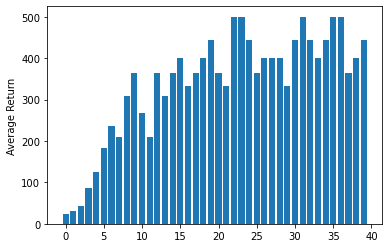

In [17]:
import matplotlib.pyplot as plt

plt.bar(range(epochs), mean_returns)
plt.ylabel('Average Return')
plt.show()

In [20]:
# test the trained variable 

test_length = 100
passed = []

observation= env.reset()
reward_sum = 0
done 
for i in tqdm(range(test_length)):
    observation = env.reset()
    terminal = False
    done = False
    reward_sum = 0

    while not terminal:

        env.render()
        
        observation = observation.reshape(1, -1)
            
        logits, action = sample_action(observation)
        
        observation_new, reward, done, _ = env.step(action[0].numpy())
        reward_sum += reward
        terminal = done 
        observation = observation_new
   
   
    passed.append(reward_sum)



print(f'Average reward over 100 episodes {sum(passed)} / {test_length}.')

100%|██████████| 100/100 [02:28<00:00,  1.48s/it]

Average reward over 100 episodes 47659.0 / 100.
